In [1]:
import matplotlib.pyplot as plt
import numpy as np

from keras.applications.vgg16 import VGG16
from keras.models import  Sequential, Model
from keras.layers import Input, Conv2D, Dense,Flatten
from keras.optimizers import Adam
from keras.utils import to_categorical


Using TensorFlow backend.


In [2]:
!git clone https://github.com/aielawady/Siameser.git
import Siameser.core as core
import Siameser.utils as utils

Cloning into 'Siameser'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 50 (delta 23), reused 27 (delta 10), pack-reused 0
Unpacking objects: 100% (50/50), done.


In [0]:
# !wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
# !tar -xf cifar-10-python.tar.gz

# import pickle
# def unpickle(file):
#     import pickle
#     with open(file, 'rb') as fo:
#         dict = pickle.load(fo, encoding='bytes')
#     return dict

# train_x = unpickle('cifar-10-batches-py/data_batch_1')[b'data']
# train_y = np.array(unpickle('cifar-10-batches-py/data_batch_1')[b'labels'])

# for i in range(1,6):
#   batch = unpickle('cifar-10-batches-py/data_batch_'+str(i))
#   train_x = np.append(train_x,batch[b'data'], axis=0)
#   train_y = np.append(train_y,batch[b'labels'], axis=0)

# train_x = train_x.reshape(60000,3,32,32).transpose(0,2,3,1)
# train_y = np.array(train_y)

# batch = unpickle('cifar-10-batches-py/test_batch')
# test_x = batch[b'data']
# test_y = np.array(batch[b'labels'])
# test_x = test_x.reshape(10000,3,32,32).transpose(0,2,3,1)
# test_y = np.array(test_y)

In [4]:
!pip install python-mnist
!wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz

  Created wheel for python-mnist: filename=python_mnist-0.6-py2.py3-none-any.whl size=11662 sha256=0c8ee3827684e5e0491b4b283bb766063905385da597e17c9b508fa3d18a6116
  Stored in directory: /root/.cache/pip/wheels/28/29/36/408f83545a511c43d03ef997a1dc99b49ccd5f9f306ed92468
Successfully built python-mnist
--2019-09-28 14:50:09--  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 216.165.22.6
Connecting to yann.lecun.com (yann.lecun.com)|216.165.22.6|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9.45M  5.87MB/s    in 1.6s    

2019-09-28 14:50:12 (5.87 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2019-09-28 14:50:13--  http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 216.165.22.6
Connecting to yann.lecun.com (yan

In [0]:
from mnist import MNIST
mnist = MNIST('.')
mnist.gz = True
train_x, train_y = mnist.load_training()
test_x, test_y = mnist.load_testing()

train_x = np.expand_dims(np.array(train_x).reshape(-1,28,28), axis=3)/255
train_y = np.array(train_y)
test_x = np.expand_dims(np.array(test_x).reshape(-1,28,28), axis=3)/255
test_y = np.array(test_y)

In [6]:
train_x.shape

(60000, 28, 28, 1)

3


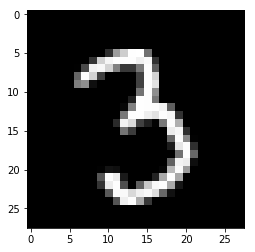

In [7]:
plt.imshow(train_x[30000].squeeze(), cmap='gray')
print(train_y[30000])

In [8]:
train_siamese = utils.tripler(np.arange(len(train_x)), train_y, classnames=set(train_y))
assert(utils.triplets_checker(np.arange(len(train_x)), train_y, train_siamese))
utils.triplets_dist_display(np.arange(len(train_x)), train_y, train_siamese)

Anchor histogram:
 [5889 6876 6082 6159 5892 5328 5764 6209 5838 5963] 

 Anchors-Positives histogram:
 [[5889.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0. 6876.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0. 6082.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0. 6159.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0. 5892.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0. 5328.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0. 5764.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0. 6209.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0. 5838.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0. 5963.]] 

 Anchors-Negatives histogram:
 [[  0. 744. 601. 687. 632. 559. 617. 675. 677. 697.]
 [766.   0. 809. 774. 780. 692. 767. 789. 766. 733.]
 [684. 754.   0. 693. 653. 676. 681. 697. 562. 682.]
 [650. 821. 695.   0. 689. 583. 655. 697. 678. 691.]
 [682. 731. 665. 661

In [9]:
x_input = Input(shape=(28,28,1))
# base_model = VGG16(include_top=False, input_tensor=x_input, weights='imagenet', input_shape=(32,32,3), pooling='Max')
# x = base_model.output
x = Conv2D(8, (3,3), padding='same', activation='relu')(x_input)
x = Conv2D(8, (3,3), padding='same', activation='relu')(x)
x = Conv2D(8, (3,3), padding='same', activation='relu')(x)
x = Conv2D(16, (3,3), padding='same', activation='relu')(x)
x = Conv2D(16, (3,3), padding='same', activation='relu')(x)
x = Conv2D(16, (3,3), padding='same', activation='relu')(x)
x = Conv2D(16, (3,3), padding='same', activation='relu')(x)
x = Conv2D(32, (3,3), padding='same', activation='relu')(x)
x = Conv2D(32, (3,3), padding='same', activation='relu')(x)
x = Conv2D(32, (3,3), padding='same', activation='relu')(x)
x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = Conv2D(8, (1,1), padding='same', activation='relu')(x)
x = Flatten()(x)
x = Dense(128, activation='tanh')(x)
feature_extractor = Model(inputs=x_input, outputs=[x], name='fextractor_model')
feature_extractor.summary()





Model: "fextractor_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 8)         80        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 8)         584       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 8)         584       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 16)        1168      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 16)

In [10]:
siamese_model = core.siamese_modeller(feature_extractor,input_shape=(28,28,1))
X_loaded = [np.zeros((60000, 28,28, 1), dtype='float32') for i in range(3)]
for i, ID in enumerate(train_siamese.T):
    for j in range(3):
        X_loaded[j][i,:,:,:] = train_x[ID[j]]

siamese_model.compile(optimizer=Adam(1e-4),
                      loss=core.loss(0.2),
                      metrics=[core.metric])
siamese_model.fit(X_loaded, np.zeros((len(X_loaded[0]),)), batch_size=128, epochs=5)

Creating and training the model...
Stacking the layers...

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
60000/60000 [==============================] - 92s 2ms/step - loss: 0.0308 - metric: 0.9456
Epoch 2/5
60000/60000 [==============================] - 85s 1ms/step - loss: 0.0071 - metric: 0.9868
Epoch 3/5
60000/60000 [==============================] - 86s 1ms/step - loss: 0.0046 - metric: 0.9915
Epoch 4/5
60000/60000 [==============================] - 86s 1ms/step - loss: 0.0035 - metric: 0.9939
Epoch 5/5
60000/60000 [==============================] - 86s 1ms/step - loss: 0.0026 - metric: 0.9948


In [11]:
for layer in feature_extractor.layers:
  layer.trainable=False
x_in = Input(shape=(28,28,1))
x = feature_extractor(x_in)
x = Dense(10, activation='softmax')(x)
classifier = Model(inputs=[x_in], outputs=[x])
classifier.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
classifier.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
fextractor_model (Model)     (None, 128)               1260936   
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 1,262,226
Trainable params: 1,290
Non-trainable params: 1,260,936
_________________________________________________________________


In [12]:
train_y = to_categorical(train_y)
test_y = to_categorical(test_y)

classifier.fit(train_x, train_y, batch_size=128, epochs=10, validation_data=(test_x, test_y))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 13s 221us/step - loss: 1.1582 - acc: 0.8621 - val_loss: 0.5178 - val_acc: 0.9758
Epoch 2/10
60000/60000 [==============================] - 13s 215us/step - loss: 0.3503 - acc: 0.9785 - val_loss: 0.2327 - val_acc: 0.9795
Epoch 3/10
60000/60000 [==============================] - 13s 214us/step - loss: 0.1933 - acc: 0.9803 - val_loss: 0.1503 - val_acc: 0.9803
Epoch 4/10
60000/60000 [==============================] - 13s 215us/step - loss: 0.1374 - acc: 0.9809 - val_loss: 0.1139 - val_acc: 0.9813
Epoch 5/10
60000/60000 [==============================] - 13s 214us/step - loss: 0.1096 - acc: 0.9813 - val_loss: 0.0940 - val_acc: 0.9815
Epoch 6/10
60000/60000 [==============================] - 13s 216us/step - loss: 0.0934 - acc: 0.9816 - val_loss: 0.0817 - val_acc: 0.9821
Epoch 7/10
60000/60000 [==============================] - 13s 215us/step - loss: 0.0828 - acc: 0.9819 - val_loss: 0.

In [13]:
for layer in classifier.get_layer('fextractor_model').layers:
  layer.trainable=False
for layer in classifier.get_layer('fextractor_model').layers[-3:]:
  layer.trainable=True

classifier.compile(optimizer=Adam(1e-4),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
classifier.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
fextractor_model (Model)     (None, 128)               1260936   
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 1,262,226
Trainable params: 805,266
Non-trainable params: 456,960
_________________________________________________________________


In [14]:
classifier.fit(train_x, train_y, batch_size=64, epochs=10, validation_data=(test_x, test_y))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 16s 268us/step - loss: 0.0504 - acc: 0.9849 - val_loss: 0.0413 - val_acc: 0.9865
Epoch 2/10
60000/60000 [==============================] - 15s 258us/step - loss: 0.0372 - acc: 0.9887 - val_loss: 0.0379 - val_acc: 0.9865
Epoch 3/10
60000/60000 [==============================] - 16s 259us/step - loss: 0.0324 - acc: 0.9905 - val_loss: 0.0346 - val_acc: 0.9887
Epoch 4/10
60000/60000 [==============================] - 15s 258us/step - loss: 0.0290 - acc: 0.9911 - val_loss: 0.0380 - val_acc: 0.9869
Epoch 5/10
60000/60000 [==============================] - 15s 258us/step - loss: 0.0260 - acc: 0.9921 - val_loss: 0.0377 - val_acc: 0.9879
Epoch 6/10
60000/60000 [==============================] - 15s 257us/step - loss: 0.0236 - acc: 0.9925 - val_loss: 0.0397 - val_acc: 0.9878
Epoch 7/10
60000/60000 [==============================] - 15s 257us/step - loss: 0.0220 - acc: 0.9934 - val_loss: 0.